<a href="https://colab.research.google.com/github/juDEcorous/Heart-Disease-Prediction/blob/main/Prediction_for_Heart_Failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **Heart Disease Prediction**

Context:

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

Data Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## Target:

**The target for this data set to predict whether or not, patients would develop heart failure exacerbation using the risk factors of heart Disease.**

This will be a Classification Metrics.


## Data Dictionary

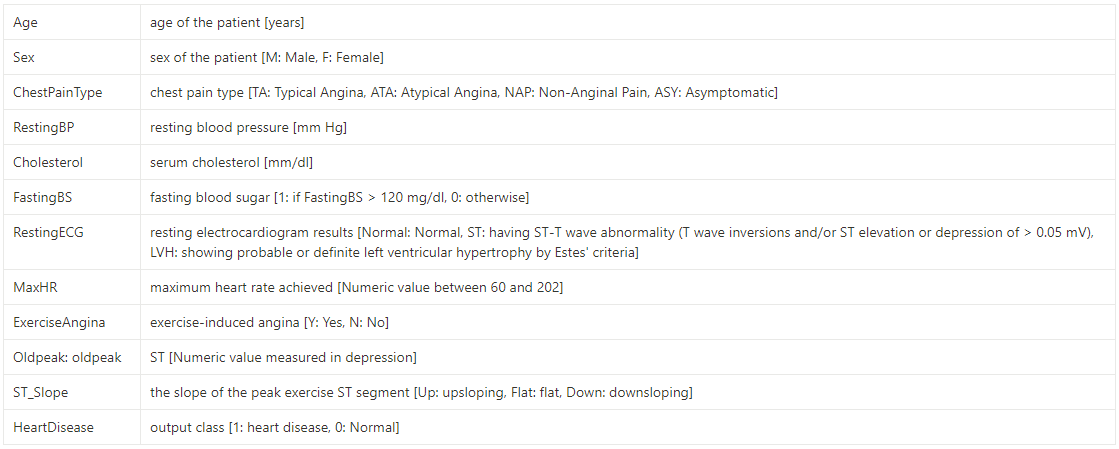



# Imports


In [1]:
# pandas
import pandas as pd

# numpy
import numpy as np

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

# metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, \
recall_score, precision_score, f1_score, classification_report, \
confusion_matrix, roc_auc_score

# balancing dataset
from imblearn.pipeline import make_pipeline as resample_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# PCA
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Data Inspection

In [2]:
path = 'heart.csv'

In [3]:
hf = pd.read_csv(path)
hf.info()
hf.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
13    49   M           ASY        140          234          0     Normal   
354   55   M           ASY        120            0          0         ST   
401   51   M           ASY        130            0          1         ST   
810   55   F           ATA        135          250          0        LVH   
292   53   M           ASY        130          182          0     Normal   
679   63   M            TA        145          233          1        LVH   
363   56   M           ASY        120            0          0         ST   
44    43   M           ASY        120          175          0     Normal   
374   61   M           ASY        125            0          0     Normal   
170   29   M           ATA        120          243          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
13     140              Y      1.0     Flat             1  
354     92              N      0.3       Up             1  
401    163              N      0.0     Flat             1  
810    161              N      1.4     Flat             0  
292    148              N      0.0       Up             0  
679    150              N      2.3     Down             0  
363    148              N      0.0     Flat             1  
44     120              Y      1.0     Flat             1  
374    105              Y      0.0     Down             1  
170    160              N      0.0       Up             0

In [4]:
#Check and address duplicates
hf.duplicated().sum()

0

In [5]:
#Check and address missing values
hf.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
#check target balance
hf.HeartDisease.value_counts(normalize = True)*100

1    55.337691
0    44.662309
Name: HeartDisease, dtype: float64

We have an imbalance target in favor of Heart Disease, which means that our metrics can be misleading. The prediction will be more bias towards predicting Heart Disease. We need to balance our model before doing predictions. (1) Balanced, (2) Oversampled, (3) Undersampled and (4) SMOTE methods will be use to balance our target.

## Numerical Columns

In [7]:
hf.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

In [8]:
#checking 0 values in Resting BP
hf.loc[hf.RestingBP == 0]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP          0            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N      1.5     Flat             1

In [9]:
#checking 0 values in Cholesterol
hf.loc[hf.Cholesterol == 0].sample(5)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
400   50   F           ASY        160            0          1     Normal   
475   59   M           ASY        178            0          1        LVH   
453   60   M           ASY        120            0          0     Normal   
402   65   M           ASY        145            0          1         ST   
427   59   M           ASY        140            0          0         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
400    110              N      0.0     Flat             1  
475    120              Y      0.0     Flat             1  
453    133              Y      2.0       Up             0  
402     67              N      0.7     Flat             1  
427    117              Y      1.0     Flat             1

- **Age Column** are within normal range.
- **RestingBP** have 200 value on it which TOO high but is not impossible as high BP (180/100 mmHG) are actually associated with heart attack, stroke or other life-threatening health problems. A resting BP of 0 is suspicious so we need to drop that sample, if this means that the patient is gone, I believe it is better if sample will not be included in our data set.
- Under the **Cholesterol** column, our 75th percentile value 267 and the max value is 603 which is about twice as many. Also, our minimum shows 0 which is suspicious and there are 172 samples with this value. ***For this 0 values I will be converting them as a missing value.*** While doing research, I noticed that the system of unit used was **mm/dL** and most of my sources used **mg/dL**. I am not sure if converting the units from mm/dL to mg/dL would be of any use. For this column we need to ask more details to the Medical Professionals or the one who gathers the data for more informations and  confirmation. But as for now, I will treat the value of measurement as a type error because the values seems to be in mg/dL.</br> 
sources: 
  * https://www.medicalnewstoday.com/articles/cholesterol-over-500#:~:text=Triglyceride%20levels%20over%20500%20mg,for%20heart%20disease%20and%20stroke
  * https://www.urmc.rochester.edu/encyclopedia/content.aspx?contenttypeid=167&contentid=lipid_panel_nonhdl#:~:text=Less%20than%2070%20milligrams%20per,159%20mg%2FdL%20%E2%80%93%20borderline%20high
- **FastingBS** column looks suspicious but it is under ordinal, in this case 1 are those patients who has has >120 mg/dL result on Fasting Blood Sugar, and 0 are those who have < 120 mg/dL  
- **MaxHR** column looks normal
- As for our **Oldpeak** column. 6.2 seems to be an impossible together with 5 and 5.6. However, this is possible - this ST depression happen when the coronary artery blockage is extensive.
- **HeartDisease** column shows us weather a patient have heart disease or not

For now we are going to remove the impossible values (0) in RestingBP column.


In [10]:
hf.drop(449, inplace = True)

In [11]:
#checking if the row with 0 value on BP has been dropped
hf.loc[hf.RestingBP == 0]

Empty DataFrame
Columns: [Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease]
Index: []

I will convert the 0 values in Cholesterol column as a missing value.

In [12]:
hf['Cholesterol'] = hf['Cholesterol'].replace(0, np.nan)
hf.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  917.000000  917.000000   746.000000  917.000000  917.000000   
mean    53.509269  132.540894   244.635389    0.233370  136.789531   
std      9.437636   17.999749    59.153524    0.423206   25.467129   
min     28.000000   80.000000    85.000000    0.000000   60.000000   
25%     47.000000  120.000000   207.250000    0.000000  120.000000   
50%     54.000000  130.000000   237.000000    0.000000  138.000000   
75%     60.000000  140.000000   275.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  917.000000    917.000000  
mean     0.886696      0.552890  
std      1.066960      0.497466  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

In [13]:
hf.isna().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

source: https://my.clevelandclinic.org/health/articles/11920-cholesterol-numbers-what-do-they-mean


## Categorical Column

In [14]:
data_types = hf.dtypes
obj_data = data_types[(data_types == 'object')]

for column in obj_data.index:
  print(column)
  print(f'Unique Values: {hf[column].unique()}\n')

Sex
Unique Values: ['M' 'F']

ChestPainType
Unique Values: ['ATA' 'NAP' 'ASY' 'TA']

RestingECG
Unique Values: ['Normal' 'ST' 'LVH']

ExerciseAngina
Unique Values: ['N' 'Y']

ST_Slope
Unique Values: ['Up' 'Flat' 'Down']



We have no inconsistencies in Categorical Column but we need to rename the Exercise Angina to Ordinal.

In [15]:
# Replacing the value
hf['ExerciseAngina'].replace({'N' : 0, 'Y' : 1}, inplace =True)
hf['ExerciseAngina'] = hf['ExerciseAngina'].astype(int)

#check
hf.sample(3)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
217   54   M           NAP        120        217.0          0     Normal   
184   54   F           ATA        160        312.0          0     Normal   
351   43   M           ASY        140          NaN          0         ST   

     MaxHR  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
217    137               0      0.0       Up             0  
184    130               0      0.0       Up             0  
351    140               1      0.5       Up             1

## Exploratory Data Analysis

In [16]:
numerical_columns = list(hf.select_dtypes(include = 'number'))
categorical_columns = list(hf.select_dtypes(include = 'object'))

### Numerical EDA

Histogram will help us see the how frequently a value falls into a particular bin. Also, outliers can also be seen with this graph.


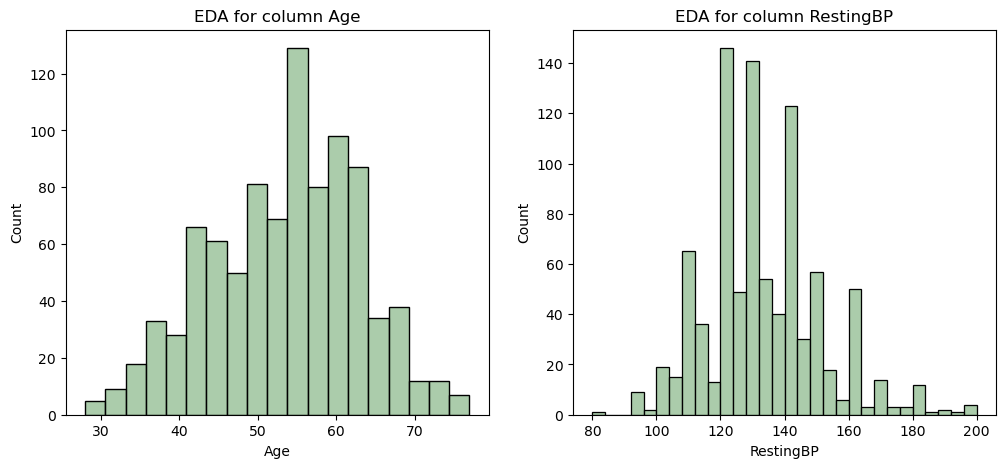

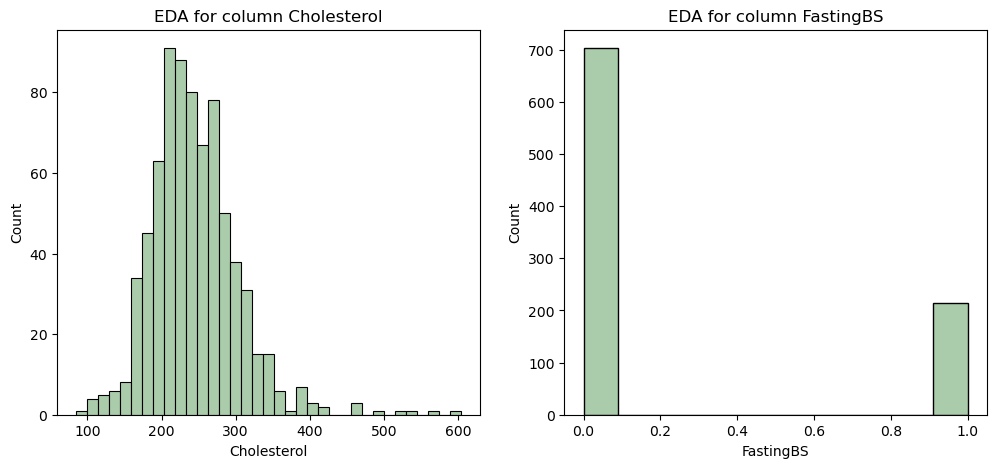

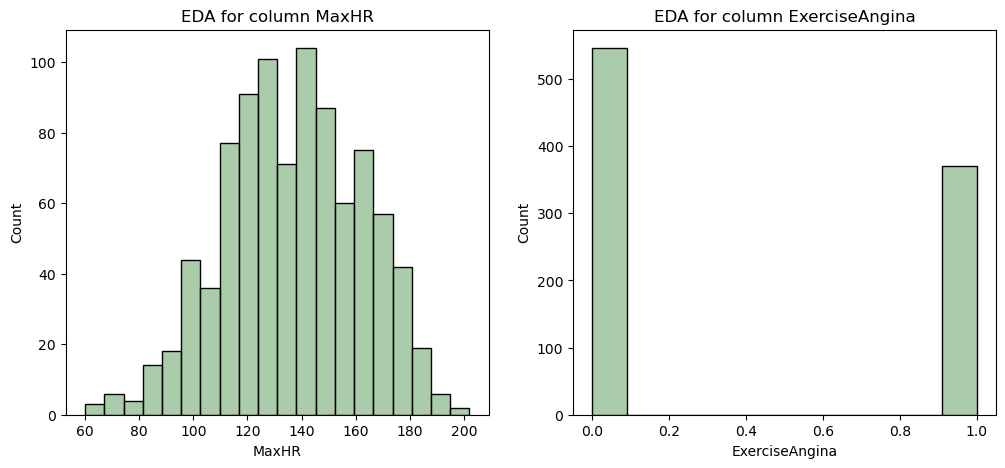

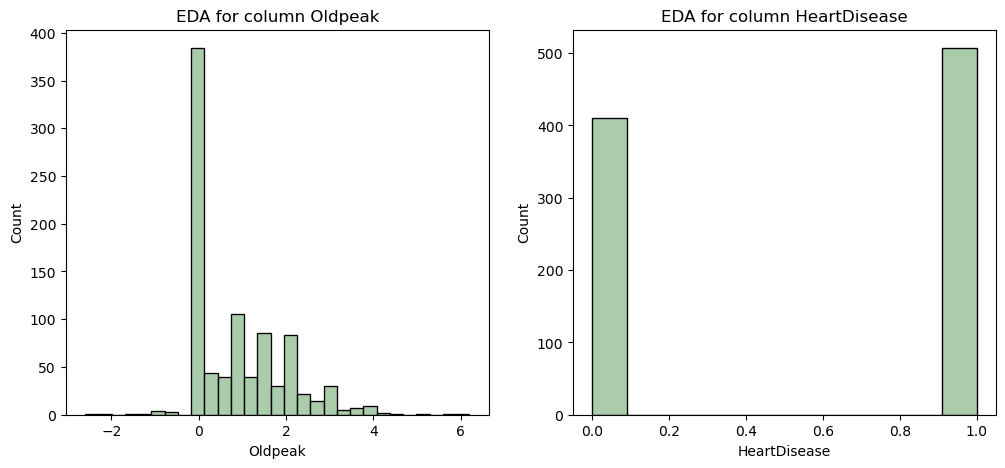

In [17]:
col_ax = 0
row_limit = 3
counter = 0
fix, axes = plt.subplots(ncols = 2, figsize = (12, 5))

for column in numerical_columns:
    
    column_name = column
    
    ax = sns.histplot(data = hf, x = column, bins = 'auto', 
                      color = 'darkseagreen', ax = axes[col_ax])
    ax.set_title('EDA for column ' + column_name)

    
    if col_ax == 1 and counter != row_limit:
        fig, axes = plt.subplots(ncols = 2, figsize = (12, 5))
        col_ax = 0
        counter += 1
    else:
        col_ax += 1

- Right-skewed distribution is seen on RestingBP and Cholesterol.
- Left-skewed distribution Age column.
- Outliers are seen RestingBP, Cholestrol, and OldPeak
- Max HR column shows Non-symmetric Bimodal distribution.
- In this graph, we can see how imbalanced our target (Heart Disease) is.

### Categorical EDA

Countplot will help us see how the count of categorical observations in each bin.

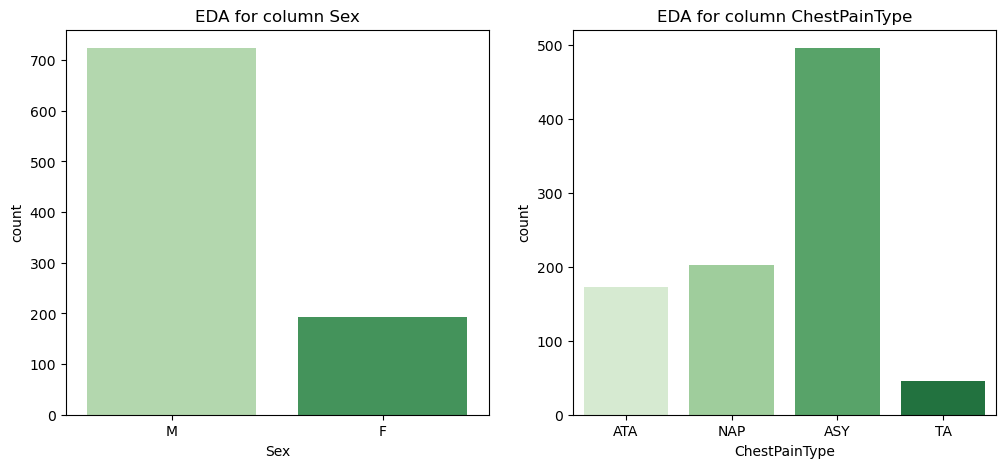

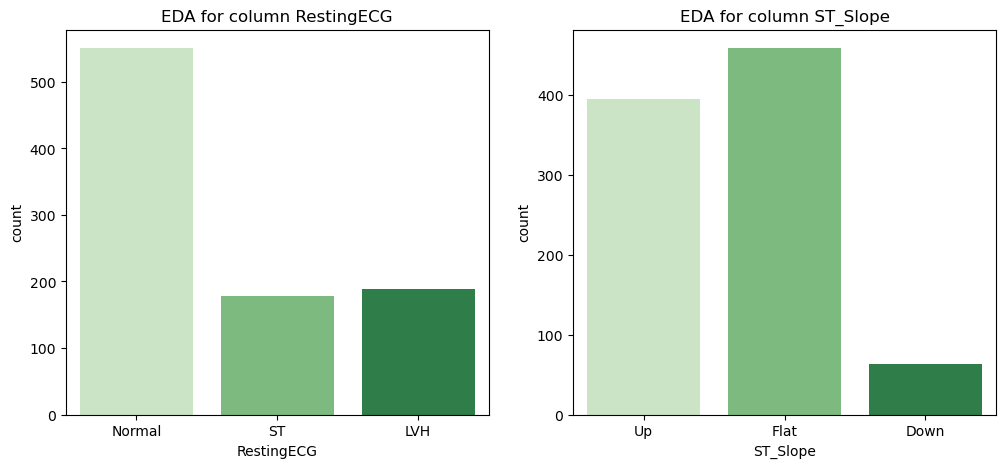

In [18]:
col_ax = 0
row_limit = 1
counter = 0
fix, axes = plt.subplots(ncols = 2, figsize = (12, 5))

for column in categorical_columns:
    
    column_name = column
    
    ax = sns.countplot(data = hf, x = column, 
                      palette = 'Greens', ax = axes[col_ax])
    ax.set_title('EDA for column ' + column_name)

    
    if col_ax == 1 and counter != row_limit:
        fig, axes = plt.subplots(ncols = 2, figsize = (12, 5))
        col_ax = 0
        counter += 1
    else:
        col_ax += 1

- Sex Column shows that our dataset have more male patients that female patients.
- Interestingly, ChestPainType column suggest that the dataset that most patient have Asymptomatic(ASY) symptom. Typical angina (ATA) or Angina Pectoris is when heart does not get enough oxygenated blood because of blockage. This means that we expect more patients to have this symptom than others.
- RestingECG also have an interesting result because if ECG is normal in all Lead, then heart failure is unlikely. And yet the graph shows that most patients have normal ECG when we have more patients with Heart Disease for this dataset.
- Upwards (ST elevation) is associated with Myocardial injury or also known as Heart Attack. Downwards (ST depression) is associated with Myocardial Ischemia, blockage of coronary artery. For this column, we are expecting to have more Up and Down values. Instead the graph shows that the data set has more Flat ST slope(Normal). 

I believe that Exercise tolerance testing was done to get the ST segment slope during Peak Exercise. An article indicates that, "The normal ST segment during exercise slopes sharply upwards." Also the same article suggest that, "The standard criterion for an abnormal ST segment response is horizontal (planar) or downsloping depression of >1 mm."

**Article:** https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1123032/#:~:text=Normal%20trace%20during%20exercise&text=The%20normal%20ST%20segment%20during,ms%20after%20the%20J%20point.


### Correlation Heatmap

<AxesSubplot: >

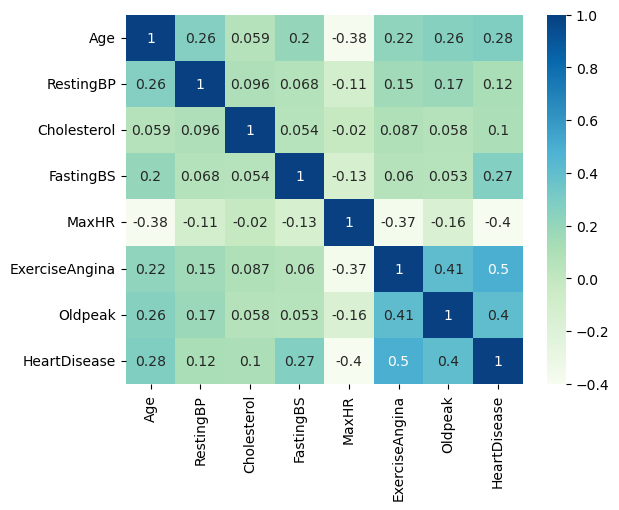

In [19]:
corr = hf.corr()
sns.heatmap(corr, annot = True, cmap = 'GnBu')

Generally speaking seems like our dataset doesn't have a good correlation with each other. 

- Our target doesn't have any strong or moderate correlation with our Numerical Columns. However, a low correlation is seen between our target and columns MaxHR and Oldpeak.


## Explanatory Visual Analysis

In [20]:
fig1 = px.pie(hf, values = 'HeartDisease', names = 'Sex',
              title = 'Number of Patients with Heart Disease',
              color_discrete_sequence = px.colors.sequential.Darkmint)
fig1.show()

- This Pie Chart shows the gender distribution of patients with Heart Disease. As we can see, in this data set 90.1% of our patients who have Heart Disease are Male and 9.86% are the female patients with heart Disease.

In [57]:
fig2 = px.bar(hf, x = 'HeartDisease', y = 'ChestPainType',
              title = 'Chest Pain Types of Patients with Heart Disease',
              color_discrete_sequence = px.colors.sequential.Aggrnyl)
fig2.show()

- Typical angina (ATA) or Angina Pectoris is when heart does not get enough oxygenated blood because of blockage. This means that we expect more patients to have this symptom than others. This Bar graph shows the types of chest pain the patients with Heart Disease have. Surprisingly, most of our patients with the disease shows to have an Asymptomatic Chest Pain. Non-Anginal Pain(NAP) comes second. Typical Angina and Atypical Angina have almost the same ratio and there is about 25 patients with this Chest Pain. It seems like most of our patients with Heart Disease doesn't show much Angina than what I expected them to.

In [58]:
fig3 = px.bar(hf, x = 'HeartDisease', y = 'ST_Slope',
              title = 'ST Segment slope during Peak Exercise',
              color_discrete_sequence = px.colors.sequential.Aggrnyl)
fig3.show()

- Upwards (ST elevation) is associated with Myocardial injury or also known as Heart Attack. Downwards (ST depression) is associated with Myocardial Ischemia, blockage of coronary artery. For this column, we are expecting to have more Up and Down values. Instead the graph shows that the data set has more Flat ST slope(Normal).

In [64]:
fig4 = px.histogram(hf, x = 'Age', y = 'HeartDisease',
                    title = 'Ages of Patients with Heart Disease',
                    color_discrete_sequence = px.colors.sequential.Aggrnyl)
fig4.show()

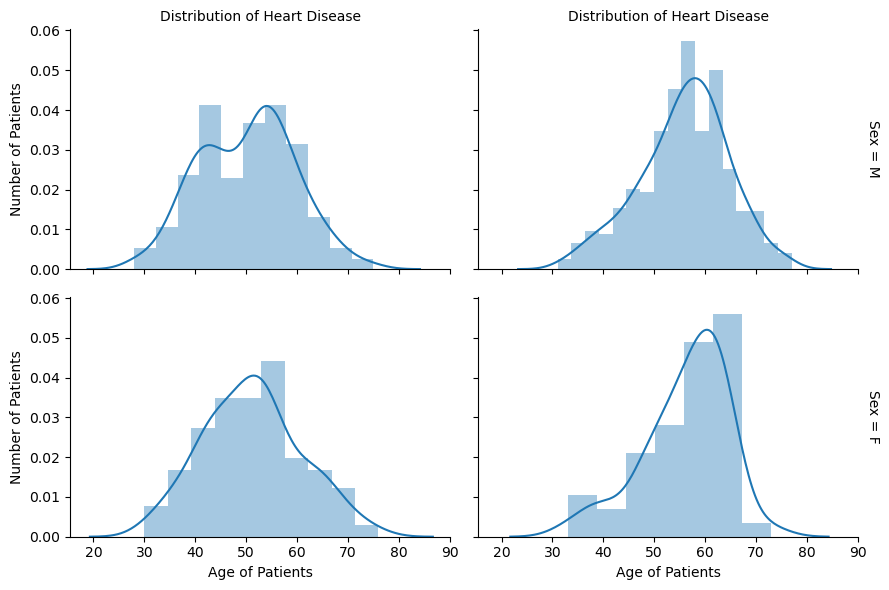

In [21]:
fg = sns.FacetGrid(hf, col = 'HeartDisease', row = 'Sex', aspect = 1.5, margin_titles=True)
fg.map(sns.distplot, 'Age')
fg.set_axis_labels('Age of Patients', 'Number of Patients')
fg.set_titles(col_template = 'Distribution of Heart Disease')

- This graph shows the distribution of patients with heart disease by age per gender. As we can see we don't have a normal distribution on age - Most of our patients are in Late Middle age. We have few patients in Late Adulthood as well as in Early Middle age. According to research Late Adulthood (65 and above) are more at risk that any other age group. However, on this graph we see that the peak is at about age 60. 
- Another thing to note in this graph is the fact that most of our Healthy (patients who does not have heart disease) are in Early Middle Age. This is true for both male and female.

# Machine Learning


We know that our target is the Heart Disease. We need to know the type 1 (False Positive) and the type 2 (False negative) errors in this dataset.

1. *Type 1 (False Positive) error* in this data set would mean that we predicted that **the patient have the Heart Disease but does not**.
2. *Type 2 (False Negative) error* in this data set would mean that we predicted that **the patient DO NOT have Heart Disease but actually have**.

With these in mind, it is safe to assume that we need to minimize having type 2 (False Negative) errors in our data set.

A source stated that: "The ROC AUC score tells us how efficient the model is. The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes."

When we start comparing models, our goal is to choose a model with the highest Recall, Accuracy and ROC AUC Score. And of course lowest False Negative Errors. 

# Default Dataset
## Functions used

In [22]:
## Functions for modeling with balanced target

#balancing
under_sample = RandomUnderSampler(random_state = 42)
over_sample = RandomOverSampler(random_state = 42)
smote_sample = SMOTE(random_state = 42)

#storing metrics
metrics_df = pd.DataFrame()

#labels for heart disease
labels = ['No DSE', 'With DSE']


def balancing(X_train, X_test, y_train, y_test, preprocessor_number,
              model, name):
    
    ## Model
    # balanced model
    balance = model(class_weight = 'balanced', random_state = 42)
    balance_pipe = make_pipeline(preprocessor_number, balance)
    balance_pipe.fit(X_train, y_train)
    balance_test_pred = balance_pipe.predict(X_test)
    
    # undersampled model
    under = model(random_state = 42)
    under_pipe = resample_pipeline(preprocessor_number, under_sample, under)
    under_pipe.fit(X_train, y_train)
    under_test_pred = under_pipe.predict(X_test)
    
    # oversampled model
    over = model(random_state = 42)
    over_pipe = resample_pipeline(preprocessor_number, over_sample, over)
    over_pipe.fit(X_train, y_train)
    over_test_pred = over_pipe.predict(X_test)
    
    # SMOTE model
    smote = model(random_state = 42)
    smote_pipe = resample_pipeline(preprocessor_number, smote_sample, smote)
    smote_pipe.fit(X_train, y_train)
    smote_test_pred = smote_pipe.predict(X_test)

    fig, axes = plt.subplots(2, 2, figsize = (10, 5)) 
    
    #balanced
    axes[0, 0].set_title(f'Balanced {name}')
    ConfusionMatrixDisplay.from_predictions(y_test, balance_test_pred,
                                            normalize = 'true',
                                            display_labels = labels,
                                            cmap = 'BuGn', ax = axes[0, 0])
    #oversampled
    axes[1, 0].set_title(f'Oversampled {name}')
    ConfusionMatrixDisplay.from_predictions(y_test, over_test_pred,
                                            normalize = 'true',
                                            display_labels = labels,
                                            cmap = 'BuGn', ax = axes[1, 0])
    #undersampled
    axes[0, 1].set_title(f'Undersampled {name}')
    ConfusionMatrixDisplay.from_predictions(y_test, under_test_pred,
                                            normalize = 'true',
                                            display_labels = labels, 
                                            cmap = 'BuGn', ax = axes[0, 1])
    #SMOTE
    axes[1, 1].set_title(f'SMOTE {name}')
    ConfusionMatrixDisplay.from_predictions(y_test, smote_test_pred,
                                            normalize = 'true',
                                            display_labels = labels, 
                                            cmap = 'BuGn', ax = axes[1, 1])
    plt.tight_layout()
    
    #Scores
    #balanced
    metrics_df.at[(f'Balanced {name}'), 
                  'Test Accuracy'] = accuracy_score(y_test, balance_test_pred)
    metrics_df.at[(f'Balanced {name}'), 
                  'Test Recall (Sensitivity)'] = recall_score(y_test,
                                                              balance_test_pred)
    metrics_df.at[(f'Balanced {name}'), 
                  'Test Precision'] = precision_score(y_test, 
                                                      balance_test_pred)
    metrics_df.at[(f'Balanced {name}'), 
                  'Test F1'] = f1_score(y_test, balance_test_pred)
    
    metrics_df.at[(f'Balanced {name}'), 
                  'Test ROC AUC'] = roc_auc_score(y_test, balance_test_pred)    

    #undersampled
    metrics_df.at[(f'Undersampled {name}'), 
                  'Test Accuracy'] = accuracy_score(y_test, under_test_pred)
    metrics_df.at[(f'Undersampled {name}'), 
                  'Test Recall (Sensitivity)'] = recall_score(y_test,
                                                              under_test_pred)
    metrics_df.at[(f'Undersampled {name}'), 
                  'Test Precision'] = precision_score(y_test, under_test_pred)
    metrics_df.at[(f'Undersampled {name}'), 
                  'Test F1'] = f1_score(y_test, under_test_pred)
    metrics_df.at[(f'Undersampled {name}'), 
                  'Test ROC AUC'] = roc_auc_score(y_test, under_test_pred)         

    #oversampled
    metrics_df.at[(f'Oversampled {name}'), 
                  'Test Accuracy'] = accuracy_score(y_test, over_test_pred)
    metrics_df.at[(f'Oversampled {name}'), 
                  'Test Recall (Sensitivity)'] = recall_score(y_test, 
                                                              over_test_pred)
    metrics_df.at[(f'Oversampled {name}'), 
                  'Test Precision'] = precision_score(y_test, over_test_pred)
    metrics_df.at[(f'Oversampled {name}'), 
                  'Test F1'] = f1_score(y_test, over_test_pred)
    metrics_df.at[(f'Oversampled {name}'), 
                  'Test ROC AUC'] = roc_auc_score(y_test, over_test_pred)    

    #SMOTE
    metrics_df.at[(f'SMOTE {name}'), 
                  'Test Accuracy'] = accuracy_score(y_test, smote_test_pred)
    metrics_df.at[(f'SMOTE {name}'), 
                  'Test Recall (Sensitivity)'] = recall_score(y_test, 
                                                              smote_test_pred)
    metrics_df.at[(f'SMOTE {name}'), 
                  'Test Precision'] = precision_score(y_test, smote_test_pred)
    metrics_df.at[(f'SMOTE {name}'), 
                  'Test F1'] = f1_score(y_test, smote_test_pred)
    metrics_df.at[(f'SMOTE {name}'), 
                  'Test ROC AUC'] = roc_auc_score(y_test, smote_test_pred)    
    
    #scores in dataframe
    display(metrics_df.tail(4))

In [23]:
## Function for tuning the models 
def tuning(X_train, X_test, y_train, y_test, 
           model_pipe, model_params, model_name):
    grid = GridSearchCV(model_pipe, model_params)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
         
    #scores for dataframe                            
    metrics_df.at[(f'Tuned {model_name}'), 
                  'Test Accuracy'] = accuracy_score(y_test, y_pred)
    metrics_df.at[(f'Tuned {model_name}'), 
                  'Test Recall (Sensitivity)'] = recall_score(y_test, y_pred)
    metrics_df.at[(f'Tuned {model_name}'), 
                  'Test Precision'] = precision_score(y_test, y_pred)
    metrics_df.at[(f'Tuned {model_name}'), 
                  'Test F1'] = f1_score(y_test, y_pred)
    metrics_df.at[(f'Tuned {model_name}'),
                  'Test ROC AUC'] = roc_auc_score(y_test, y_pred)
    #best parameter for tuned model
    print(f'Best Parameters: {best_params}')
    
    #scores in dataframe
    display(metrics_df.tail(1)) 
     
    #Confusion Matrix for tuned model
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                            normalize='true',
                                            display_labels = labels,
                                            cmap='BuGn')
    plt.suptitle(f'Tuned ' + model_name);   

## Default Data Preprocessing

In [24]:
# making copy of the cleaned data set for engineering
hf2 = hf.copy()

In [25]:
hf.info()
hf.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    object 
 2   ChestPainType   917 non-null    object 
 3   RestingBP       917 non-null    int64  
 4   Cholesterol     746 non-null    float64
 5   FastingBS       917 non-null    int64  
 6   RestingECG      917 non-null    object 
 7   MaxHR           917 non-null    int64  
 8   ExerciseAngina  917 non-null    int32  
 9   Oldpeak         917 non-null    float64
 10  ST_Slope        917 non-null    object 
 11  HeartDisease    917 non-null    int64  
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 89.6+ KB


Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140        289.0          0     Normal    172   
1   49   F           NAP        160        180.0          0     Normal    156   
2   37   M           ATA        130        283.0          0         ST     98   
3   48   F           ASY        138        214.0          0     Normal    108   
4   54   M           NAP        150        195.0          0     Normal    122   

   ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0               0      0.0       Up             0  
1               0      1.0     Flat             1  
2               0      0.0       Up             0  
3               1      1.5     Flat             1  
4               0      0.0       Up             0

In [26]:
# Test / Train Split
target = 'HeartDisease'

y = hf[target]
X = hf.drop(columns = target)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [27]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (687, 11)
X_test shape: (230, 11)
y_train shape: (687,)
y_test shape: (230,)


We have missing value in the Cholesterol column for this dataset, we need to use SimpleImputer. We are going to impute the median for this column because this method is less affected by outliers than strategy = 'mean'. OrdinalEncoder is not needed as we have renamed the columns already.

Ordinal Features = ExerciseAngina, FastingBS </br>
Nominal Features = Sex, ChestPainType, RestingECG, ST_Slope</br>
Numerical Features = Age, RestingBP, Cholesterol, MaxHR, Oldpeak

- Note that RestingECG cannot be an Ordinal because we don't know which is worst, having thick and enlarge heart (LVH) or having abnormal ST slope (ST).	

In [28]:
ordinal_features = ['ExerciseAngina', 'FastingBS']
ord_scaler = StandardScaler()
ord_tuple = (ord_scaler, ordinal_features)

In [29]:
nominal_features = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope']
ohe = OneHotEncoder(handle_unknown = 'ignore')
nom_tuple = (ohe, nominal_features)

In [30]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
median_imputer = SimpleImputer(strategy = 'median')
num_scaler = StandardScaler()

num_pipe = make_pipeline(median_imputer, num_scaler)

num_tuple = (num_pipe, numerical_features)

In [31]:
preprocessor = make_column_transformer (ord_tuple, nom_tuple, num_tuple,
                                       remainder = 'drop')

In [32]:
# Checking if preprocessor works
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['ExerciseAngina', 'FastingBS']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ST_Slope']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR',
                                  'Oldpeak'])])

### Model 1: Decision Tree

Test Accuracy  Test Recall (Sensitivity)  \
Balanced Decision Tree           0.808696                   0.800000   
Undersampled Decision Tree       0.804348                   0.800000   
Oversampled Decision Tree        0.804348                   0.785714   
SMOTE Decision Tree              0.778261                   0.750000   

                            Test Precision   Test F1  Test ROC AUC  
Balanced Decision Tree            0.875000  0.835821      0.811111  
Undersampled Decision Tree        0.868217  0.832714      0.805556  
Oversampled Decision Tree         0.880000  0.830189      0.809524  
SMOTE Decision Tree               0.867769  0.804598      0.786111

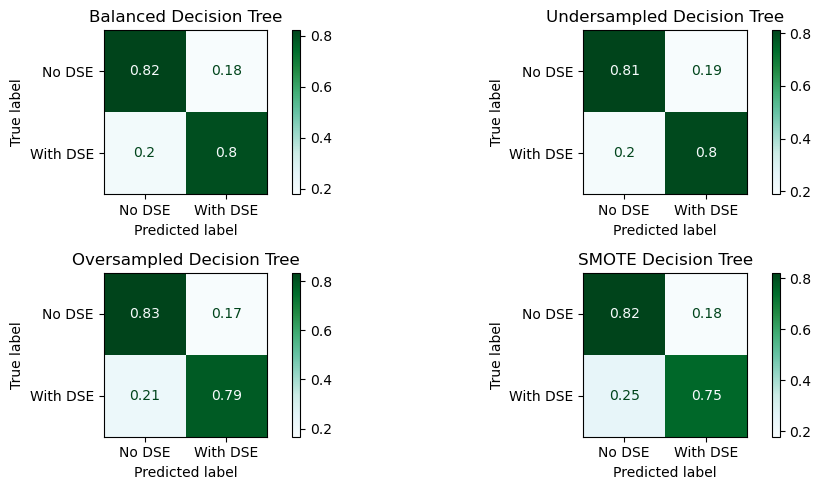

In [33]:
dt = balancing(X_train, X_test, y_train, y_test, preprocessor,
               DecisionTreeClassifier, 'Decision Tree')

**Decision Tree Model:**
- All of our balanced set have more than 20% Type II errors.
- 80% is the highest Sensitivity metrics: Balanced and Undersampled.
- 80% is the highest Accuracy.
- ROC AUC score is low on this model.

### Model 2: Random Forest

Test Accuracy  Test Recall (Sensitivity)  \
Balanced Random Forest           0.882609                   0.892857   
Undersampled Random Forest       0.878261                   0.878571   
Oversampled Random Forest        0.878261                   0.885714   
SMOTE Random Forest              0.860870                   0.857143   

                            Test Precision   Test F1  Test ROC AUC  
Balanced Random Forest            0.912409  0.902527      0.879762  
Undersampled Random Forest        0.917910  0.897810      0.878175  
Oversampled Random Forest         0.911765  0.898551      0.876190  
SMOTE Random Forest               0.909091  0.882353      0.861905

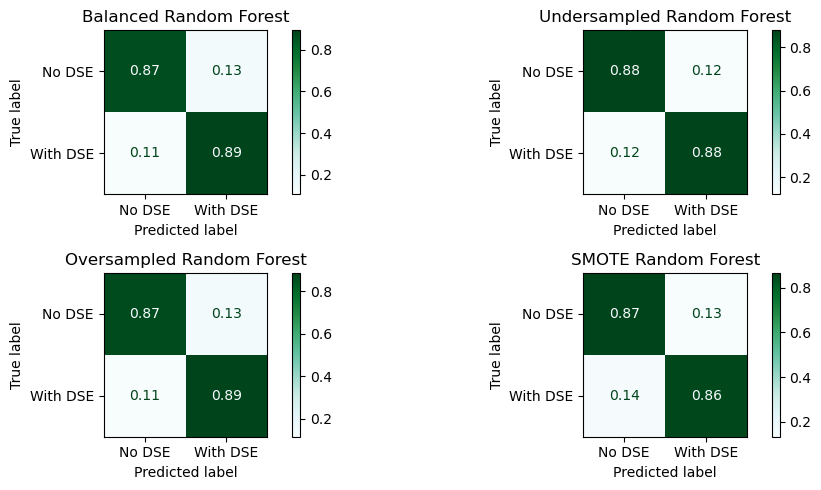

In [34]:
rf = balancing(X_train, X_test, y_train, y_test, preprocessor,
               RandomForestClassifier, 'Random Forest')

**Random Forest Model:**
- 11% Type II errors are seen in Balanced and Oversampled. **this could be a good model*
- Balanced model have a high Sensitivity of 89.29%. Next in line is the Oversampled model with 88.57%.
- High Accuracy is seen with no lower than 86%.
- ROC AUC scores are somewhat high, having 87% for three balanced mode.

### Model 3: Support Vector Machines

Test Accuracy  \
Balanced Support Vector Machines           0.865217   
Undersampled Support Vector Machines       0.860870   
Oversampled Support Vector Machines        0.869565   
SMOTE Support Vector Machines              0.878261   

                                      Test Recall (Sensitivity)  \
Balanced Support Vector Machines                       0.864286   
Undersampled Support Vector Machines                   0.850000   
Oversampled Support Vector Machines                    0.871429   
SMOTE Support Vector Machines                          0.878571   

                                      Test Precision   Test F1  Test ROC AUC  
Balanced Support Vector Machines            0.909774  0.886447      0.865476  
Undersampled Support Vector Machines        0.915385  0.881481      0.863889  
Oversampled Support Vector Machines         0.910448  0.890511      0.869048  
SMOTE Support Vector Machines               0.917910  0.897810      0.878175

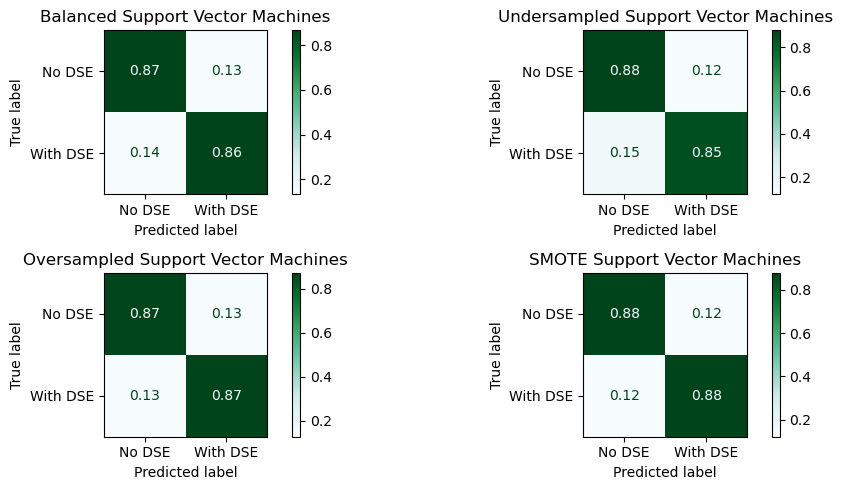

In [35]:
svm = balancing(X_train, X_test, y_train, y_test, preprocessor,
                SVC, 'Support Vector Machines')

**Support Vector Machines Model:**
- Lowest type II error seen on SMOTE model with only 12%
- Smote model also have the highest Sensitivity score of 87.86% and highest Accuracy of 87.82% as well as ROC AUC Score of 87.81%.
- Smote set performs best for this model.

### Model 4: Light Gradient Boosting

Test Accuracy  \
Balanced Light Gradient Boosting           0.865217   
Undersampled Light Gradient Boosting       0.878261   
Oversampled Light Gradient Boosting        0.882609   
SMOTE Light Gradient Boosting              0.873913   

                                      Test Recall (Sensitivity)  \
Balanced Light Gradient Boosting                       0.850000   
Undersampled Light Gradient Boosting                   0.864286   
Oversampled Light Gradient Boosting                    0.885714   
SMOTE Light Gradient Boosting                          0.878571   

                                      Test Precision   Test F1  Test ROC AUC  
Balanced Light Gradient Boosting            0.922481  0.884758      0.869444  
Undersampled Light Gradient Boosting        0.930769  0.896296      0.882143  
Oversampled Light Gradient Boosting         0.918519  0.901818      0.881746  
SMOTE Light Gradient Boosting               0.911111  0.894545      0.872619

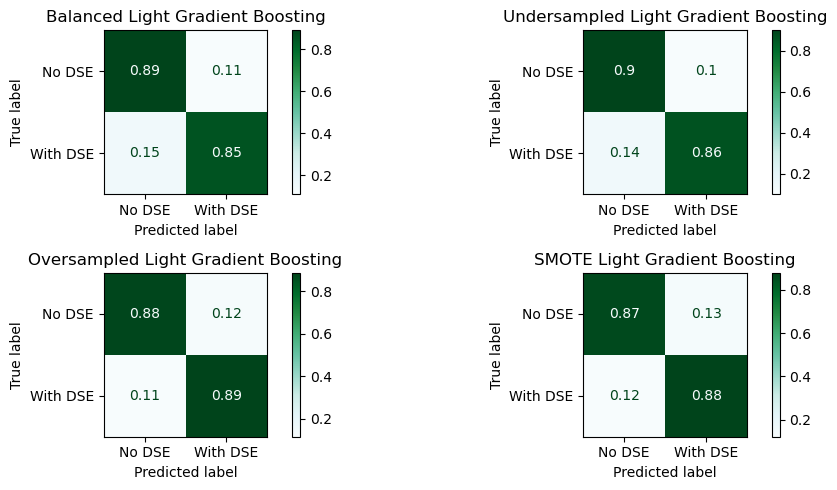

In [36]:
lfbm = balancing(X_train, X_test, y_train, y_test, preprocessor,
                 LGBMClassifier, 'Light Gradient Boosting')

**Light Gradient Boosting Model:**

- 11% Type II Error is noted on oversampled set
- Oversampled out-perform the other balanced sets, having the highest Sensitivity and Accuracy. However, Undersampled have a little higher ROC AUC score.

## Default Models Findings

In [37]:
display(metrics_df.sort_values(by = 'Test Recall (Sensitivity)',  
                               ascending = False))

Test Accuracy  \
Balanced Random Forest                     0.882609   
Oversampled Random Forest                  0.878261   
Oversampled Light Gradient Boosting        0.882609   
Undersampled Random Forest                 0.878261   
SMOTE Support Vector Machines              0.878261   
SMOTE Light Gradient Boosting              0.873913   
Oversampled Support Vector Machines        0.869565   
Balanced Support Vector Machines           0.865217   
Undersampled Light Gradient Boosting       0.878261   
SMOTE Random Forest                        0.860870   
Undersampled Support Vector Machines       0.860870   
Balanced Light Gradient Boosting           0.865217   
Balanced Decision Tree                     0.808696   
Undersampled Decision Tree                 0.804348   
Oversampled Decision Tree                  0.804348   
SMOTE Decision Tree                        0.778261   

                                      Test Recall (Sensitivity)  \
Balanced Random Forest                                 0.892857   
Oversampled Random Forest                              0.885714   
Oversampled Light Gradient Boosting                    0.885714   
Undersampled Random Forest                             0.878571   
SMOTE Support Vector Machines                          0.878571   
SMOTE Light Gradient Boosting                          0.878571   
Oversampled Support Vector Machines                    0.871429   
Balanced Support Vector Machines                       0.864286   
Undersampled Light Gradient Boosting                   0.864286   
SMOTE Random Forest                                    0.857143   
Undersampled Support Vector Machines                   0.850000   
Balanced Light Gradient Boosting                       0.850000   
Balanced Decision Tree                                 0.800000   
Undersampled Decision Tree                             0.800000   
Oversampled Decision Tree                              0.785714   
SMOTE Decision Tree                                    0.750000   

                                      Test Precision   Test F1  Test ROC AUC  
Balanced Random Forest                      0.912409  0.902527      0.879762  
Oversampled Random Forest                   0.911765  0.898551      0.876190  
Oversampled Light Gradient Boosting         0.918519  0.901818      0.881746  
Undersampled Random Forest                  0.917910  0.897810      0.878175  
SMOTE Support Vector Machines               0.917910  0.897810      0.878175  
SMOTE Light Gradient Boosting               0.911111  0.894545      0.872619  
Oversampled Support Vector Machines         0.910448  0.890511      0.869048  
Balanced Support Vector Machines            0.909774  0.886447      0.865476  
Undersampled Light Gradient Boosting        0.930769  0.896296      0.882143  
SMOTE Random Forest                         0.909091  0.882353      0.861905  
Undersampled Support Vector Machines        0.915385  0.881481      0.863889  
Balanced Light Gradient Boosting            0.922481  0.884758      0.869444  
Balanced Decision Tree                      0.875000  0.835821      0.811111  
Undersampled Decision Tree                  0.868217  0.832714      0.805556  
Oversampled Decision Tree                   0.880000  0.830189      0.809524  
SMOTE Decision Tree                         0.867769  0.804598      0.786111

In [38]:
display(metrics_df.sort_values(by = 'Test Recall (Sensitivity)',  
                               ascending = False).head(1))

Test Accuracy  Test Recall (Sensitivity)  \
Balanced Random Forest       0.882609                   0.892857   

                        Test Precision   Test F1  Test ROC AUC  
Balanced Random Forest        0.912409  0.902527      0.879762

- Decision Tree did not perform very well in our dataset. The highest Sensitivity it can get is 80% with no higher than 81% Accuracy. False Negatives are high in this model with no lower than 20%.</br>
- The highest Sensitivity we have is 89.28% from **Balanced Random Forest** Model. It also have the highest Accuracy amongst all the models used at 88.26%.
- Second highest Sensitivity is 88.57%. These Sensitivity score is seen on Models:
    - **Oversampled Light Gradient Boosting** with 88.26% Accuracy. We should also note that Light Gradient Boosting have the highest ROC AUC score for all the models used in this dataset.
    - **Oversampled Random Forest** with 87.82% Accuracy.
- Third highest is at score of 87.85% from three different models in which two of them have 87.82% and one have slightly lower. 
    - **Undersampled Random Forest**
    -**SMOTE Support Vector Machines**

    
These **Bolded** models are which I can define the top 5 models that performs well for our dataset. These models will be tuned to see if we can get an even better results.

# Tuning Models
### Tuned Model 1: Balanced Random Forest

In [39]:
bal_rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
bal_rf_pipe = make_pipeline(preprocessor, bal_rf)
tuning(X_train, X_test, y_train, y_test, bal_rf_pipe, 
       {'randomforestclassifier__n_estimators' : range(10, 110, 10),
        'randomforestclassifier__max_depth' : range(1, 11),
        'randomforestclassifier__min_samples_leaf' : [1, 2, 3],
        'randomforestclassifier__min_samples_split' : [1, 2, 3, 10]}, 
       'Balanced Random Forest')

KeyboardInterrupt: 

**Tuned Balanced Random Forest:**
- There's no change in type II errors and Accuracy.
- The defaulted model did show potential. However, we see lower Sensitivity for the tuned model.

### Tuned Model 2: SMOTE Light Gradient Boosting

In [ ]:
lgbm_over = LGBMClassifier(random_state = 42)
lgbm_over_sampler = RandomOverSampler()
lgbm_over_pipe = resample_pipeline(preprocessor, lgbm_over_sampler, lgbm_over)
tuning(X_train, X_test, y_train, y_test, lgbm_over_pipe,
       {'lgbmclassifier__max_depth' : range(1, 21),
        'lgbmclassifier__min_child_samples' : range(1, 26)}, 
       'Oversampled Light Gradient Boosting')

**Tuned SMOTE Light Gradient Boosting:**
- Increase in Type II error by 2% is observed in this model.
- Decrease of Accuracy and Sensitivity is also observed.
- The defaulted model performs better than this tuned model.

### Tuned Model 3: Oversampled Random Forest

In [ ]:
over_rf = RandomForestClassifier(random_state = 42)
over_rf_sampler = RandomOverSampler()
over_rf_pipe = resample_pipeline(preprocessor, over_rf_sampler, over_rf)
tuning(X_train, X_test, y_train, y_test, bal_rf_pipe, 
       {'randomforestclassifier__n_estimators' : range(10, 110, 10),
        'randomforestclassifier__max_depth' : range(1, 11),
        'randomforestclassifier__min_samples_leaf' : [1, 2, 3],
        'randomforestclassifier__min_samples_split' : [1, 2, 3, 10]}, 
       'Oversampled Random Forest')

**Tuned Oversampled Random Forest:**
- No changed on Type II errors.
- Same Sensitivity score as the default model.
- Increased in Accuracy by 1% is observed.
- This model is almost the same the the defaulted model.

### Tuned Model 4: Undersampled Random Forest

In [ ]:
under_rf = RandomForestClassifier(random_state = 42)
under_rf_sampler = RandomUnderSampler()
under_rf_pipe = resample_pipeline(preprocessor, over_rf_sampler, over_rf)
tuning(X_train, X_test, y_train, y_test, bal_rf_pipe, 
       {'randomforestclassifier__n_estimators' : range(10, 110, 10),
        'randomforestclassifier__max_depth' : range(1, 11),
        'randomforestclassifier__min_samples_leaf' : [1, 2, 3],
        'randomforestclassifier__min_samples_split' : [1, 2, 3, 10]}, 
       'Undersampled Random Forest')

**Tuned Undersampled Random Forest:**
- Decreased in Type II error, from 12% to 11%.
- Sensitivity and Accuracy scores has increased.
- This model performs better then the defaulted version.


### Tuned Model 5: SMOTE Support Vector Machines

In [ ]:
svc_smote = SVC(random_state = 42)
svc_smote_sampler = RandomOverSampler()
svc_smote_pipe = resample_pipeline(preprocessor, svc_smote_sampler, svc_smote)
tuning(X_train, X_test, y_train, y_test, svc_smote_pipe, 
       {'svc__C' : [0.1, 1, 10, 100],
         'svc__gamma' : [1, 0.1, 0.01, 0.001],
         'svc__kernel' : ['rbf', 'poly', 'sigmoid']}, 
       'SMOTE Support Vector Machines')

**Tuned SMOTE Support Vector Machines:**
- 2% increased in Type II error is seen in this tuned model.
- There's an increased in Sensitivy compared to defaulted model.
- Tuned and default model almost have the same rate of Accuracy.
- This model did not do well on tuning version.

## Default Model Findings

In [ ]:
# Score of the best model in Default dataset
display(metrics_df.sort_values(by = 'Test Recall (Sensitivity)',  
                               ascending = False).head(1))

In [ ]:
#Tuned Scores
metrics_df.head(21)

- Having our focus on Sensitivity Metrics, together with the False Negatives and Accuracy. It clearly shows the Balanced Random Forest Model has the best metrics we have seen for this data set. The downside of this model however, is the fact that it is not the model with the highest ROC AUC score. We should note that the highest score (88.21 from Undersampled Light Gradient Boosting) is not too far-off from this model's score.
    * Type II Error: 11%
    * Sensitivity Score: 89.28%
    * Accuracy Score: 88.26% 
    * ROC AUC Score: 87.97%
    
- None of the tuned models actually performs better than the Balanced Random Forest. For this reason we are going to try tuning the exact models with Principal Component Analysis (PCA) and compare the tuned metrics for the non-PCA and the PCA model


## with PCA

### PCA Tuned 1: Balanced Random Forest

In [ ]:
pca = PCA(n_components = .95)

bal_rf_pca = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
bal_rf_pca_pipe = make_pipeline(preprocessor, pca, bal_rf_pca)
tuning(X_train, X_test, y_train, y_test, bal_rf_pca_pipe, 
       {'randomforestclassifier__n_estimators' : range(10, 110, 10),
        'randomforestclassifier__max_depth' : range(1, 11),
        'pca__n_components' : [.90, .93, .95]},
       'Balanced PCA Random Forest')

### PCA tuned 2 : SMOTE Light Gradient Boosting

In [ ]:
lgbm_over_pca = LGBMClassifier(random_state = 42)
lgbm_over_pca_sampler = RandomOverSampler()
lgbm_over_pca_pipe = resample_pipeline(preprocessor, pca, 
                                   lgbm_over_pca_sampler, lgbm_over_pca)
tuning(X_train, X_test, y_train, y_test, lgbm_over_pca_pipe,
       {'lgbmclassifier__max_depth' : range(1, 21),
        'lgbmclassifier__min_child_samples' : range(1, 26),
        'pca__n_components' : [.90, .93, .95]}, 
       'Oversampled PCA Light Gradient Boosting')

### PCA tuned 3 : Oversampled Random Forest

In [ ]:
over_rf_pca = RandomForestClassifier(random_state = 42)
over_rf_pca_sampler = RandomOverSampler()
over_rf_pca_pipe = resample_pipeline(preprocessor, pca, 
                                     over_rf_pca_sampler, over_rf_pca)
tuning(X_train, X_test, y_train, y_test, over_rf_pca_pipe, 
       {'randomforestclassifier__n_estimators' : range(10, 110, 10),
        'randomforestclassifier__max_depth' : range(1, 11),
        'pca__n_components' : [.90, .93, .95]}, 
       'Oversampled PCA Random Forest')

### PCA tuned 4 : Undersampled Random Forest

In [ ]:
under_rf_pca = RandomForestClassifier(random_state = 42)
under_rf_pca_sampler = RandomUnderSampler()
under_rf_pca_pipe = resample_pipeline(preprocessor, pca, 
                                      under_rf_pca_sampler, under_rf_pca)
tuning(X_train, X_test, y_train, y_test, under_rf_pca_pipe, 
       {'randomforestclassifier__n_estimators' : range(10, 110, 10),
        'randomforestclassifier__max_depth' : range(1, 11),
        'randomforestclassifier__min_samples_leaf' : [1, 2, 3],
        'pca__n_components' : [.90, .93, .95]}, 
       'Undersampled PCA Random Forest')

### PCA tuned 5 : SMOTE Support Vector Machines

In [ ]:
svc_smote_pca = SVC(random_state = 42)
svc_smote_pca_sampler = RandomOverSampler()
svc_smote_pca_pipe = resample_pipeline(preprocessor, pca, 
                                       svc_smote_pca_sampler, svc_smote_pca)
tuning(X_train, X_test, y_train, y_test, svc_smote_pca_pipe, 
       {'svc__C' : [0.1, 1, 10, 100],
         'svc__gamma' : [1, 0.1, 0.01, 0.001],
         'svc__kernel' : ['rbf', 'poly', 'sigmoid'],
        'pca__n_components' : [.90, .93, .95]}, 
       'SMOTE PCA Support Vector Machines')

## PCA findings on Default Models

While comparing the Non-PCA and PCA models. 
- Only the Tuned Oversampled PCA Light Gradient Boosting made a better prediction than the Non-PCA models. 
- In general, PCA Random Forest made a bad prediction than the non-PCA version. 
- Support Vector Machines did not make a significant difference with its PCA and non-PCA models.

Even with this PCA model results, it still did not give us a better metrics than the Balanced Random Forest which we decided to be the best model. Over all, PCA did not help us with our prediction.

# Engineered Dataset

In [ ]:
hf2.info()
hf2.head()

In [ ]:
hf2.describe()

Let's bin the age group by decade.

In [ ]:
#rounding age to have age by decades
hf2['Age'] = hf2['Age'].round(-1)
hf2.rename(columns = {'Age' : 'Agebydecade'}, inplace = True)
hf2.sample(3)

Grouping the resting BP values by Blood Pressure Categories.
- source: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings?fbclid=IwAR1OBr7pxdx466Yq1gdnP9BCkWWBIV4Z6_wkjkrN4J9QQvxflUUzPhU780A

In [ ]:
diastolic = hf2['RestingBP']

def bp_reading(bp):
    if bp < 81:
        return 'Normal'
    elif bp < 90:
        return 'Highpertension Stage 1'
    elif bp < 119:
        return 'Highpertension Stage 2'
    else:
        return 'Highpertensive Crisis'

hf2['RestingBP'] = hf2['RestingBP'].apply(bp_reading)
hf2.rename(columns = {'RestingBP' : 'BP_categories'}, inplace = True)
hf2.sample(3)

Renaming the Oldpeak column on which the ST is associated with.

sources: 
- https://ieeexplore.ieee.org/document/5761212
- https://elentra.healthsci.queensu.ca/assets/modules/ECG/normal_ecg.html?fbclid=IwAR19uu-TGI4uG4jKRvv006R87YCrNrRJHuzyjmQ1uWDM5xsG3m4lWA5ba0w

In [ ]:
st = hf2['Oldpeak']

def st_reading(st_segment):
    if st_segment < -2:
        return 'Infarction'
    elif st_segment < .5:
        return 'Normal'
    else:
        return 'Ischemia'

hf2['Oldpeak'] = hf2['Oldpeak'].apply(st_reading)
hf2.rename(columns = {'Oldpeak' : 'ST_diagnosis'}, inplace = True)
hf2.sample(8)

The number of columns feels just about right. If the Engineered dataset doesn't show any improvement with the models used. We can definitely try combining columns of the same Categories.

## Engineered Data Preprocessing

In [ ]:
#we're going to use the same target
y2 = hf2[target]
X2 = hf2.drop(columns = target)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, 
                                                        random_state = 42)

Missing value is still seen in Cholesterol column for this dataset. We are going to impute the median via SimpleImputer for this method is less affected by outliers than strategy = 'mean'. 

Ordinal Features = FastingBS, ExerciseAngina </br>
Nominal Features = Sex, BP_categories, ChestPainType, RestingECG, ST_diagnosis, ST_slope</br>
Numerical Features = Agebydecade, Cholesterol, MaxHR

In [ ]:
ordinal_features2 = ['FastingBS', 'ExerciseAngina']
ord_scaler2 = StandardScaler()
ord_tuple2 = (ord_scaler2, ordinal_features2)

In [ ]:
nominal_features2 = ['Sex', 'BP_categories', 'ChestPainType', 'RestingECG', 
                     'ST_diagnosis', 'ST_Slope']
ohe2 = OneHotEncoder(handle_unknown = 'ignore')
nom_tuple2 = (ohe2, nominal_features2)

In [ ]:
numerical_features2 = ['Agebydecade', 'Cholesterol', 'MaxHR']
median_imputer2 = SimpleImputer(strategy = 'median')
num_scaler2 = StandardScaler()

num_pipe2 = make_pipeline(median_imputer2, num_scaler2)

num_tuple2 = (num_pipe2, numerical_features2)

In [ ]:
preprocessor2 = make_column_transformer(ord_tuple2, nom_tuple2, num_tuple2,
                                       remainder = 'drop')

In [ ]:
#Checking if the preprocessor works
preprocessor2.fit(X2_train, y2_train)

### Engineered Model 1: Decision Tree

In [ ]:
dt2 = balancing(X2_train, X2_test, y2_train, y2_test, preprocessor2,
               DecisionTreeClassifier, 'Engineered Decision Tree')

**Engineered Decision Tree:**
- Decision Tree did not perform well again even after we did the Feature Engineering Method.
- High Type II errors are still observed for Decision Tree model.
- Much lower sensitivity and accuracy score is seen.

### Engineered Model 2: Random Forest

In [ ]:
rf2 = balancing(X2_train, X2_test, y2_train, y2_test, preprocessor2,
               RandomForestClassifier, 'Engineered Random Forest')

**Engineered Random Forest:**
- The lowest Type II error is seen at SMOTE Engineered Random Forest.
- High sensitivity scores are seen with all the balanced mode. Highest seen is 88.57% which is again from SMOTE Engineered Random Forest.
- Oversampled Engineered Random Forest gets the highest Accuracy for this model.
- A somewhat decent ROC AUC scores.

### Engineered Model 3: Support Vector Machines

In [ ]:
svm2 = balancing(X2_train, X2_test, y2_train, y2_test, preprocessor2,
                SVC, 'Engineered Support Vector Machines')

**Engineered Support Vector Machines:**
- Somewhat low Type II Errors are seen in this model.
- Sensitivity score are kind of low, having the highest of about only 85.71%

### Engineered Model 4: Light Gradient Boosting

In [ ]:
lfbm2 = balancing(X2_train, X2_test, y2_train, y2_test, preprocessor2,
                 LGBMClassifier, 'Engineered Light Gradient Boosting')

**Engineered Light Gradient Boosting:**
- Low Type II error is seen in this model.
- Balanced Engineered Light Gradient Boosting and Oversampled Engineered Light Gradient Boosting has both the highest Sensitivity we have seen so far.
- Highest Accuracy score and ROC AUC score is also seen on Oversampled Engineered Light Gradient Boosting.

## Engineered Model Findings

In [ ]:
display(metrics_df.tail(16))

- The Decision Tree, Random Forest and Support Vector Machine did not perform better in the Engineered data set.
- Light Gradient Boosting out-performs all the models in the data set by giving us 90% Sensitivity, the highest one we have yet. 
- Oversampled Engineered Light Gradient Boosting is the best model so far when it comes to Sensitivity, Accuracy, ROC AUC and Confusion Matrix.

* Tuning the Balanced and Oversampled Light Gradient to see if we get an even better scores. PCA will also be used.


# Tuning Engineered Models
### Engineered Tuned Model 1: Oversampled Light Gradient Boosting

In [ ]:
engi_lgbm_over = LGBMClassifier(random_state = 42)
engi_lgbm_over_sampler = RandomOverSampler()
engi_lgbm_over_pipe = resample_pipeline(preprocessor2, engi_lgbm_over_sampler, 
                                        engi_lgbm_over)
tuning(X2_train, X2_test, y2_train, y2_test, engi_lgbm_over_pipe,
       {'lgbmclassifier__max_depth' : range(1, 21),
        'lgbmclassifier__min_child_samples' : range(1, 26)}, 
       'Engineered Oversampled Light Gradient Boosting')

### Engineered PCA Tuned Model: Oversampled Light Gradient Boosting

In [ ]:
engi_lgbm_over_pca = LGBMClassifier(random_state = 42)
engi_lgbm_over_pca_sampler = RandomOverSampler()
engi_lgbm_over_pca_pipe = resample_pipeline(preprocessor2, pca, 
                                            engi_lgbm_over_pca_sampler, 
                                            engi_lgbm_over_pca)
tuning(X2_train, X2_test, y2_train, y2_test, engi_lgbm_over_pca_pipe,
       {'lgbmclassifier__max_depth' : range(1, 21),
        'lgbmclassifier__min_child_samples' : range(1, 26),
        'pca__n_components' : [.90, .93, .95]}, 
       'Engineered Oversampled PCA Light Gradient Boosting')

### Engineered Tuned Model 1: Balanced Light Gradient Boosting

In [ ]:
engi_lgbm_bal = LGBMClassifier(class_weight = 'balanced', random_state = 42)
engi_lgbm_bal_pipe = resample_pipeline(preprocessor2, engi_lgbm_bal)
tuning(X2_train, X2_test, y2_train, y2_test, engi_lgbm_bal_pipe,
       {'lgbmclassifier__max_depth' : range(1, 21),
        'lgbmclassifier__min_child_samples' : range(1, 26)}, 
       'Engineered Balanced Light Gradient Boosting')

### Engineered PCA Tuned Model: Balanced Light Gradient Boosting

In [ ]:
engi_lgbm_bal_pca  = LGBMClassifier(class_weight = 'balanced', random_state = 42)
engi_lgbm_bal_pca_pipe = resample_pipeline(preprocessor2, pca, 
                                           engi_lgbm_bal_pca)
tuning(X2_train, X2_test, y2_train, y2_test, engi_lgbm_bal_pca_pipe,
       {'lgbmclassifier__max_depth' : range(1, 21),
        'lgbmclassifier__min_child_samples' : range(1, 26),
        'pca__n_components' : [.90, .93, .95]}, 
       'Engineered PCA Balanced Light Gradient Boosting')

In [ ]:
metrics_df.tail(4)

- We don't see any improvements when tuning both of our models.
- Decreased in Sensitivity is true for all the tuned models.
- Icreased in Type II errors are observed
- Over all the non-tuned models did better in this data set.

# Final Findings

In [ ]:
# score of all the models used from highest sensitivity to lowest
display(metrics_df.sort_values(by = 'Test Recall (Sensitivity)',  
                               ascending = False))

In [ ]:
# Score of the best model for Engineered Dataset
display(metrics_df.sort_values(by = 'Test Recall (Sensitivity)',  
                               ascending = False).head(1))

- Balanced Random Forest Model works best on the defaulted data set. With Sensitivity Score of 89% and Accuracy score of 88%. We also need to take note that this model have the lowest Type II error for the defaulted data set.
- In Engineered dataset, Light Gradient Boosting model shines best giving us two models with 90% Sensitivity with low Type II error score. These models are the (1) Oversampled and the (2) Balanced Light Gradient Boosting. 
- Tuning Parameters did not help us get an even better result. This is true for both defaulted and Engineered dataset.

With this regards it is safe to say that if we are using the defaulted dataset, I will recommend using the **Random Forest** with 'class_weight = balanced'. However, if the Engineered dataset is to the stakeholders liking. **Light Gradient Boosting** would be better. 'RandomOverSampler' would be best for this model as it has a higher Accuracy than 'class_weight = balanced'.
